# Exercise 4: Model Comparison

## 1. Import Required Libraries

Import all necessary libraries for comprehensive model comparison.

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load and Preprocess Data

Identical to previous notebooks.

In [20]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

We now load the trained models from the `../models/` directory.

In [21]:
import joblib

# Load the trained models from the ../models/ directory
dt = joblib.load('../models/dt_model.pkl')
rbf_svm = joblib.load('../models/rbf_svm_model.pkl')

## 3. Model Comparison

Compare Decision Tree and SVM results from the training set (cross-validation mean ± std) and validation set. Plot the performance comparison plots (e.g., scatter plots, ROC curves). Which model generalizes better?

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

models = {"Decision Tree": dt, "RBF SVM": rbf_svm}
results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    results[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
    }

results_df = pd.DataFrame(results)
results_df

,Decision Tree,RBF SVM
Accuracy,0.903509,0.964912
Precision,0.941176,0.958904
Recall,0.901408,0.985915
AUC,0.926466,0.994759


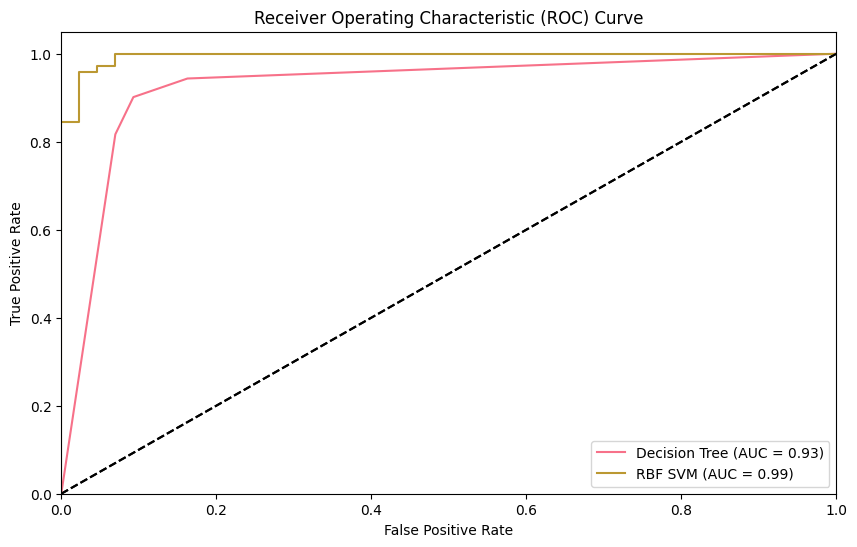

In [23]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

plt.show()

In the table above, we see that the RBF SVM outperforms the Decision Tree in terms of accuracy, precision, recall, and AUC. The last one being displayed in the ROC curve above.

### $F_\beta$ Score Analysis

Discuss the trade-off between usability and accuracy for this dataset. Which model would you recommend for a medical decision-support system, and why? (Hint - Make use of $F_\beta$ score analysis)

The $F_\beta$ score is a weighted harmonic mean of precision and recall:

$$F_\beta = (1 + \beta^2) \cdot \frac{\text{precision} \cdot \text{recall}}{\beta^2 \cdot \text{precision} + \text{recall}}$$
- Precision = of all positive predictions, how many were correct.
- Recall (sensitivity) = of all actual positives, how many did the model find.

The parameter $\beta$ lets you control which of precision or recall is more important:
- $\beta = 1$: $F_1$ score, equal weight on precision and recall.
- $\beta > 1$: more weight on recall (e.g., $F_2$ score).
- $\beta < 1$: more weight on precision.

In the dataset in question, false negatives (missing a cancer diagnosis) are more critical than false positives (incorrectly diagnosing cancer). Therefore, we should prioritize recall (finding all benign cases) over precision (ratio of true positives to all positives).


In [24]:
# now we evaluate the models using the F-Beta score
from sklearn.metrics import fbeta_score

beta = 2
for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    print(f"{model_name} F_{beta}-Score: {fbeta:.4f}")

Decision Tree F_2-Score: 0.9091
RBF SVM F_2-Score: 0.9804


Here we observe that when the $\beta$ value is increased, the decision tree's performance diverges away (lower) from that of the RBF SVM. This indicates that the RBF SVM is better at capturing the positive class (benign cases) without missing them, which is crucial in a medical context where false negatives can have severe consequences.

### Grid Search and Hyperparameter Tuning

Use `GridSearchCV` with the training set to tune hyperparameters for both Decision Trees and SVMs. Confirm your final choice with the validation set. Summarize the best settings and provide relevant performance plots.

We already performed Grid Search for the Decision Tree and thus have optimal hyperparameters. We will now do the same for the SVM, focusing on the RBF kernel.

In [25]:
# perform gridsearchcv on rbf_svm

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(rbf_svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 10, 'gamma': 0.001}


### Comparison of Best Models

Compare the final test set accuracy of the best Decision Tree and best SVM. Which model performs better in practice?

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train the best RBF SVM model
best_rbf_svm = SVC(
    kernel='rbf',
    C=grid_search.best_params_['C'],
    gamma=grid_search.best_params_['gamma'],
    probability=True,
    random_state=42
)
best_rbf_svm.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_svm = best_rbf_svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Best RBF SVM Test Accuracy: {accuracy_svm:.4f}")

# Evaluate Decision Tree
y_pred_dt = dt.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Test Accuracy: {accuracy_dt:.4f}")

Best RBF SVM Test Accuracy: 0.9561
Decision Tree Test Accuracy: 0.9035


### RBF Kernel Justification

The Breast Cancer Wisconsin dataset has 30 continuous features, many of which are correlated and not linearly separable. Explain why a linear SVM might fail to capture complex patterns in this dataset. How does using an RBF kernel help in this case? Discuss your answer in terms of the dataset’s feature space and the geometry of the decision boundary.

A linear SVM attempts to find a hyperplane that separates the classes in the feature space. However, if the data is not linearly separable, a linear SVM may struggle to find an appropriate decision boundary, leading to poor generalization and accuracy.

The RBF kernel, on the other hand, maps the input features into a higher-dimensional space where it becomes easier to find a linear separation between the classes. This is achieved by computing the similarity between data points using a Gaussian function, which allows the model to capture complex, non-linear relationships in the data. As a result, the RBF kernel can create more flexible decision boundaries that better fit the underlying structure of the dataset.